# 21. File handling: reading and writing files

# 21. Manejo de archivos: lectura y escritura de archivos

In [1]:
!pip install duckdb dill celluloid fpdf -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os, io, csv, json, glob, dbm, dill, tarfile, zipfile
import sqlite3, duckdb, yaml, fileinput, pickle, h5py, urllib
import numpy as np, pandas as pd, polars as ps, pyarrow as pa
import pylab as pl, ipywidgets as ipw, datetime, time, PIL, imageio

- `os.listdir()`
  - returns a list of all files and folders in a directory
- `os.scandir(), pathlib.Path.itrdir()`
  - returns an iterator of all objects in a directory, including file attribute information

In [3]:
path_list = []
for dirname, _, filenames in os.walk('sample_data'):
    for filename in filenames:
        path_list.append(os.path.join(dirname, filename))
path_list[0]

'sample_data/anscombe.json'

In [4]:
with os.scandir('sample_data') as entries:
    for entry in entries:
        print(entry.name)
from pathlib import Path
entries = Path('sample_data')
for entry in entries.iterdir():
    print(entry.name)

anscombe.json
README.md
california_housing_train.csv
mnist_test.csv
california_housing_test.csv
mnist_train_small.csv
anscombe.json
README.md
california_housing_train.csv
mnist_test.csv
california_housing_test.csv
mnist_train_small.csv


In [5]:
csv_list = []
for f_name in os.listdir('sample_data'):
    if f_name.endswith('.csv'):
        csv_list.append(f_name)
csv_list

['california_housing_train.csv',
 'mnist_test.csv',
 'california_housing_test.csv',
 'mnist_train_small.csv']

In [6]:
for f_name in os.listdir('sample_data/'):
    if f_name.endswith('.md'): print(f_name)

README.md


In [7]:
from pathlib import Path
p = Path('sample_data/')
for name in p.glob('*.json'):
    print(name)
for file in glob.iglob('sample_data/*small.csv', recursive=True):
    print(file)

sample_data/anscombe.json
sample_data/mnist_train_small.csv


In [8]:
def format_date(timestamp):
    d = datetime.datetime.utcfromtimestamp(timestamp)
    return d.strftime('%d %b %Y')
def get_files(n):
    c, dir_entries = 0, os.scandir('sample_data/')
    for entry in dir_entries:
        if entry.is_file() and c < n:
            print(f'{entry.name}\t was last modified: '
                  f'{format_date(entry.stat().st_mtime)}')
            c += 1
get_files(3)

anscombe.json	 was last modified: 01 Jan 2000
README.md	 was last modified: 01 Jan 2000
california_housing_train.csv	 was last modified: 04 Dec 2023


Built-in functions || Funciones integradas

`open()`

| Mode  | Description                |
|-------|----------------------------|
| 'r'   | read only                  |
| 'r+'  | read and write             |
| 'x'   | creates a file only if it does not exist |
| 'w'   | write                      |
| 'w+'  | read and write             |
| 'a'   | append                     |
| 'a+'  | read and append            |

| Modo | Descripción |
|-------|----------------------|
| 'r' | solo lectura |
| 'r+' | leer y escribir |
| 'x' | crea un archivo sólo si no existe |
| 'w' | escribir |
| 'w+' | leer y escribir |
| 'a' | anexar |
| 'a+' | leer y anexar |

In [9]:
file = open("/content/sample_data/README.md", "r")
print(file.read())
file.close()

This directory includes a few sample datasets to get you started.

*   `california_housing_data*.csv` is California housing data from the 1990 US
    Census; more information is available at:
    https://developers.google.com/machine-learning/crash-course/california-housing-data-description

*   `mnist_*.csv` is a small sample of the
    [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), which is
    described at: http://yann.lecun.com/exdb/mnist/

*   `anscombe.json` contains a copy of
    [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet); it
    was originally described in

    Anscombe, F. J. (1973). 'Graphs in Statistical Analysis'. American
    Statistician. 27 (1): 17-21. JSTOR 2682899.

    and our copy was prepared by the
    [vega_datasets library](https://github.com/altair-viz/vega_datasets/blob/4f67bdaad10f45e3549984e17e1b3088c731503d/vega_datasets/_data/anscombe.json).



In [10]:
data_file = 'data.txt'
# write mode, use `with` to automatically close the file
if data_file in os.listdir('/content'):
    os.remove(data_file)
with open(data_file, 'x') as f:
    data = 20 * '%' + '\n' + 'using  `x` mode' + '\n' + 20 * '%'
    f.write(data)
with open(data_file, 'r') as f:
    print(f.read())
# the new version of the file
with open(data_file, 'w+', encoding="utf-8") as f:
    data = 'using `w+` mode' + '\n' + 20 * '%' + '\n'
    f.write(data)
# it moves the pointer to the beginning of the file
    f.seek(0)
    print(f.read())

%%%%%%%%%%%%%%%%%%%%
using  `x` mode
%%%%%%%%%%%%%%%%%%%%
using `w+` mode
%%%%%%%%%%%%%%%%%%%%



In [11]:
# the append mode
with open(data_file, 'a+', encoding="utf-8") as f:
    data = 'using `a+` mode' + '\n' + 20 * '%' + '\n'
    f.write(data)
    f.seek(0)
# explain why the printout looks like this?
    while f.readline():
        print(f.readline())
with open(data_file, 'r') as f:
    print(f.read())

%%%%%%%%%%%%%%%%%%%%

%%%%%%%%%%%%%%%%%%%%

using `w+` mode
%%%%%%%%%%%%%%%%%%%%
using `a+` mode
%%%%%%%%%%%%%%%%%%%%



In [12]:
print(f'`{f.name}` is closed: {f.closed}')
# delete file
if os.path.isfile(data_file):
     os.remove(data_file)
else:
     print(f'Error: {data_file} is not a file name')

`data.txt` is closed: True


In [13]:
# byte-by-byte write and read / escritura y lectura byte a byte
f = open(data_file, 'wb+')
f.write(b'0123456789' + b'abcdefghij')
# the pointer is at the end of the file
# el puntero está al final del archivo
print(f.read(1))
# go to the byte 6 / # ir al byte 6
f.seek(5)
print(f.read(1))
# go to the 3rd byte from the end
# ir al tercer byte desde el final
f.seek(-3, 2)
print(f.read(1))

b''
b'5'
b'h'


In [14]:
# line-by-line writing and reading
# escritura y lectura línea por línea
data = [["Name", "Age"], ["John", 25], ["Emma", 30], ["Liam", 28]]
with open("line.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(data)
    print('Tom, 27', file=f)

In [15]:
with open('line.csv', newline='') as f:
    read = csv.reader(f, delimiter=',')
    for row in read:
        s = ' | '.join(f'%7s'%r for r in row)
        print(s, len(s) * '=', sep='\n')

   Name |     Age
   John |      25
   Emma |      30
   Liam |      28
    Tom |      27


In [16]:
# writing and reading with dictionaries
# escribir y leer con diccionarios
with open('dict.csv', 'w+', newline='') as f:
    fieldnames = ['id', 'name', 'age']
    dict_rows = ({'id':1015, 'name':'Tom', 'age':27},
                 {'id':1002, 'name':'Lisa', 'age':23},
                 {'id':1034, 'name':'Dan', 'age':21},
                 {'id':1027, 'name':'Emma', 'age':30})
    n = len(dict_rows)
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    [writer.writerow(dict_rows[i]) for i in range(n)]

In [17]:
with open('dict.csv', mode='r') as f:
    csv_reader, line_count, row_keys = csv.DictReader(f), 0, ''
    for row in csv_reader:
        line_count += 1
        if line_count == 1:
            row_keys = list(row.keys())
            n = len(row_keys)
            print(f'`{f.name}` fields: {", ".join(row)}')
        s = ' | '.join(f'{row[row_keys[i]]:7s}' for i in range(n))
        print(s, len(s) * '=', sep='\n')
    print(f'`{f.name}` contains {line_count} records')

`dict.csv` fields: id, name, age
1015    | Tom     | 27     
1002    | Lisa    | 23     
1034    | Dan     | 21     
1027    | Emma    | 30     
`dict.csv` contains 4 records


In [18]:
data = {"Name": ["John", "Emma", "Liam"],
        "Age": [25, 30, 28],
        "City": ["New York", "London", "Sydney"]}
df = pd.DataFrame(data)
df.to_excel("example.xlsx", index=False)

In [19]:
data = {"name": "John", "age": 25, "city": "New York"}
with open("example.json", "w") as f:
    json.dump(data, f)
with open("example.json", "r") as f:
    x = json.load(f)
print(x["name"], x["age"], x["city"])
with open("example.yaml", "w") as f:
    yaml.dump(data, f)

John 25 New York


In [20]:
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom import minidom
data = Element("data")
name = SubElement(data, "name")
name.text = "John"
age = SubElement(data, "age")
age.text = "25"
xml_str = minidom.parseString(tostring(data)).toprettyxml(indent="    ")
with open("example.xml", "w") as f:
    f.write(xml_str)

In [21]:
output_file = "output.txt"
output = io.StringIO()
output.write('id name age\n')
output.write('1015 Lisa 23\n')
print('1002 Tom 27', file=output)
content = output.getvalue()
output.close()
with open(output_file, "w") as f:
    f.write(content)
with open(output_file, "r") as f:
    content = f.read()
print(content)

id name age
1015 Lisa 23
1002 Tom 27



In [22]:
input_file = "output.txt"
with open(input_file, "r") as file:
    content = file.readlines()
modified_content = []
for line in content:
    modified_line = line.upper()
    modified_content.append(modified_line)
with fileinput.input(files=(input_file), inplace=True) as file:
    for line in file:
        line_no = fileinput.filelineno()
        if line_no <= len(modified_content):
            print(modified_content[line_no - 1].strip())
with open(input_file, "r") as file:
    modified_content = file.read()
print(modified_content)

ID NAME AGE
1015 LISA 23
1002 TOM 27



In [23]:
from fpdf import FPDF
pdf = FPDF(); pdf.add_page()
pdf.set_font('Times', 'B', size=14)
with open('output.txt', 'r') as f:
    for row in f:
        pdf.cell(200, 10, txt=row, ln=1, align='L')
pdf.cell(200, 10, txt="1027 EMMA 30", ln=1, align='L')
pdf.output("output.pdf")

''

In [24]:
# numpy arrays
file_name1 = 'example1.txt'
with open(file_name1, 'w+', ) as f:
    data = '1, 2, 3\n4, , 6\n7, 8, 9'
    f.write(data)
    f.seek(0)
    print(f.read(), '\n')
print(np.genfromtxt(file_name1, delimiter=",", usemask=True),
      np.genfromtxt(file_name1, delimiter=","),
      np.genfromtxt(file_name1, delimiter=",",
                    dtype=np.int16, filling_values=999),
      sep='\n\n')

1, 2, 3
4, , 6
7, 8, 9 

[[1.0 2.0 3.0]
 [4.0 -- 6.0]
 [7.0 8.0 9.0]]

[[ 1.  2.  3.]
 [ 4. nan  6.]
 [ 7.  8.  9.]]

[[  1   2   3]
 [  4 999   6]
 [  7   8   9]]


In [25]:
file_name2 = 'example2.txt'
with open(file_name2, 'w+', ) as f:
    data = '111\t22\t333\n444\t5555\t666\n77777\t\t999'
    f.write(data)
    f.seek(0)
    print(f.read(), '\n')
print(np.genfromtxt(file_name2, delimiter="\t", missing_values=" +"),
      np.genfromtxt(file_name2, delimiter=4),
      sep='\n\n')

111	22	333
444	5555	666
77777		999 

[[1.1100e+02 2.2000e+01 3.3300e+02]
 [4.4400e+02 5.5550e+03 6.6600e+02]
 [7.7777e+04        nan 9.9900e+02]]

[[ 111.   nan   33.]
 [ 444. 5555.  666.]
 [7777.   nan   99.]]


Datasets and Databases as Files

Conjuntos de datos y bases de datos como archivos

In [26]:
today = datetime.datetime.now()
data = [{'hello': 'hola'}, 1, 2.3333, 3+4j, True, "i", b"j",
        ("t", [[["z"], "y"], "x"]), {'today', today}]
with open('example.pickle', 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('example.pickle', 'rb') as f:
    loaded_data = pickle.load(f)
data == loaded_data, data is loaded_data

(True, False)

In [27]:
if os.path.exists('example.db'):
    os.remove('example.db')
def db_connect(dbf):
    sqlconn = None
    try:
        sqlconn = sqlite3.connect(dbf)
        return sqlconn
    except sqlite3.Error as err:
        print(err)
        if sqlconn is not None:
            sqlconn.close()
def db_query(connection, query):
    try:
        cursor = connection.cursor()
        tr = []; cursor.execute(query)
        print("the request was successful")
        result = cursor.fetchall()
        for r in result: tr += [r]
        if tr == []: return None
        else: return tr
    except sqlite3.Error as err:
        print(f"error: '{err}'")
dbc = db_connect('example.db')

In [28]:
users_table = """
CREATE TABLE IF NOT EXISTS users (
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  name TEXT NOT NULL,
  age INTEGER,
  gender TEXT,
  country TEXT
);
"""
db_query(dbc, users_table)
users = """
INSERT INTO
  users (name, age, gender, country)
VALUES
  ('James', 45, 'male', 'USA'),
  ('Leila', 32, 'female', 'France'),
  ('Brigitte', 35, 'female', 'UK'),
  ('Mike', 40, 'male', 'Germany'),
  ('Mary', 28, 'female', 'Canada');
"""
db_query(dbc, users)

the request was successful
the request was successful


In [29]:
# rename the file / cambiar el nombre del archivo
if os.path.exists('example.db'):
     os.rename('example.db', 'example2.db')
# it has no effect on requests / no tiene efecto en las solicitudes
db_query(dbc, """SELECT * FROM users""")

the request was successful


[(1, 'James', 45, 'male', 'USA'),
 (2, 'Leila', 32, 'female', 'France'),
 (3, 'Brigitte', 35, 'female', 'UK'),
 (4, 'Mike', 40, 'male', 'Germany'),
 (5, 'Mary', 28, 'female', 'Canada')]

In [30]:
data = {'ID': [1, 2, 3, 4, 5],
        'Name': ['Microsoft', 'Apple', 'Netflix', 'Spotify', 'Intel']}
# pandas dataframe => duckdb
pandas_df = ps.DataFrame(data)
duck_db = duckdb.sql('select * from pandas_df')
print(duck_db, type(duck_db))

┌───────┬───────────┐
│  ID   │   Name    │
│ int64 │  varchar  │
├───────┼───────────┤
│     1 │ Microsoft │
│     2 │ Apple     │
│     3 │ Netflix   │
│     4 │ Spotify   │
│     5 │ Intel     │
└───────┴───────────┘
 <class 'duckdb.duckdb.DuckDBPyRelation'>


In [31]:
# duckdb => pandas dataframe
pandas_df = duck_db.df()
print(pandas_df, type(pandas_df), sep='\n')

   ID       Name
0   1  Microsoft
1   2      Apple
2   3    Netflix
3   4    Spotify
4   5      Intel
<class 'pandas.core.frame.DataFrame'>


In [32]:
# duckdb => polars dataframe
polars_df = duck_db.pl()
print(type(polars_df))
# polars dataframe => csv
polars_df.write_csv("polars_df.csv")

<class 'polars.dataframe.frame.DataFrame'>


In [33]:
# csv => pandas dataframe
pandas_df = pd.read_csv("polars_df.csv")
# csv => polars dataframe
polars_df = ps.scan_csv("polars_df.csv")


In [34]:
arrow_df = pa.Table.from_pydict(data)
# pyarrow => duckdb
duck_db = duckdb.sql('select * from arrow_df')
# duckdb => pyarrow
arrow_df = duck_db.arrow()
# pyarrow => parquet
import pyarrow.parquet as pq
pq.write_table(arrow_df, "example.parquet")
arrow_df = pq.read_table("example.parquet")
print(arrow_df, type(arrow_df), sep='\n')

pyarrow.Table
ID: int64
Name: string
----
ID: [[1,2,3,4,5]]
Name: [["Microsoft","Apple","Netflix","Spotify","Intel"]]
<class 'pyarrow.lib.Table'>


Object-Oriented Interactions || Interacciones orientadas a objetos

In [35]:
class PickleExample:
    def __init__(self):
        self.obj1 = 1001
        self.obj2 = 10.01
        self.obj3 = "string"
        # it is impossible to save an object with the pickle module
        # es imposible guardar un objeto con el módulo pickle
        self.obj4 = lambda x: x ** 3
    def __getstate__(self):
        attributes = self.__dict__.copy()
        # object exception during saving
        # excepción de objeto durante el guardado
        del attributes['obj4']
        return attributes
    # return an object during unpacking
    # devolver un objeto durante el desembalaje
    def __setstate__(self, state):
        self.__dict__ = state
        self.obj4 = lambda x: x ** 3
pe = PickleExample()
pe_string = pickle.dumps(pe)
pe_obj = pickle.loads(pe_string)
print(*(item for item in pe_obj.__dict__.items()), sep='\n')

('obj1', 1001)
('obj2', 10.01)
('obj3', 'string')
('obj4', <function PickleExample.__setstate__.<locals>.<lambda> at 0x782510a72170>)


In [36]:
# dill - pickle extension / extensión de pickle
cube = lambda x: x ** 3
dpe = dill.dumps(cube)
[dpe[i * 30: (i + 1) * 30] for i in range(8)]

[b'\x80\x04\x95\xd2\x00\x00\x00\x00\x00\x00\x00\x8c\ndill._dill\x94\x8c\x10_cre',
 b'ate_function\x94\x93\x94(h\x00\x8c\x0c_create_co',
 b'de\x94\x93\x94(C\x00\x94K\x01K\x00K\x00K\x01K\x02KCC\x08|\x00d\x01\x13\x00S',
 b'\x00\x94NK\x03\x86\x94)\x8c\x01x\x94\x85\x94\x8c\x1f<ipython-input',
 b'-36-b72e1db5cbb2>\x94\x8c\x08<lambda>\x94K',
 b'\x02C\x02\x08\x00\x94))t\x94R\x94c__builtin__\n__mai',
 b'n__\nh\x0bNNt\x94R\x94}\x94}\x94\x8c\x0f__annotation',
 b's__\x94}\x94s\x86\x94b.']

Processing multiple files || Procesando múltiples archivos

In [37]:
files = ('example1.txt', 'example2.txt')
with fileinput.input(files=files, encoding="utf-8") as f:
    for line in f:
        if fileinput.isfirstline():
            print(f'\n! reading `{fileinput.filename()}` !')
        print(' -> ' + line, end='')


! reading `example1.txt` !
 -> 1, 2, 3
 -> 4, , 6
 -> 7, 8, 9
! reading `example2.txt` !
 -> 111	22	333
 -> 444	5555	666
 -> 77777		999

Temporary files || Archivos temporales

In [38]:
from tempfile import TemporaryFile
# create a temporary file and fill it with data
# crear un archivo temporal y llenarlo con datos
fp = TemporaryFile('w+t')
fp.write( """Name,Age\nJohn,25\nEmma,30""")
# move to the start and read / ir al inicio y leer
fp.seek(0)
data = fp.read()
# close and destroy the file
# cerrar y destruir el archivo
fp.close()
print(data)

Name,Age
John,25
Emma,30


In [39]:
# another variant / otra variante
with TemporaryFile('w+t') as fp:
    fp.write('Name,Age\nJohn,25\nEmma,30')
    fp.seek(0)
    data = fp.read()
# the file is already closed and destroyed
# el archivo ya está cerrado y destruido
print(data)

Name,Age
John,25
Emma,30


Image Files || Archivos de imagen

In [40]:
# .png for animation / .png para animación
iw_img, h, w = ipw.Image(), 300, 300
display(iw_img)
g = 210 * np.ones((h, w, 3), dtype=np.uint8)
c = np.array([h//2, w//2], dtype=int)
for i in range(120, 360):
    r, theta = i/3, i/2
    p = c + r * np.array([np.cos(theta), np.sin(theta)])
    (y, x) = p.astype(int)
    rgb = np.array([i-120, 0, 360-i], dtype=np.uint8)
    gray = np.array([255, 255, 255], dtype=np.uint8)
    g[y-2:y+3, x-2:x+3, :] = gray
    g[y:y+4, x:x+4, :] = rgb
    pil_img = PIL.Image.fromarray(g)
    with io.BytesIO() as bio:
        pil_img.save(bio, format='png')
        png = bio.getvalue()
    iw_img.value = png
    time.sleep(.3)

Image(value=b'')

In [41]:
from skimage.transform import resize
def process(arr, img_size):
    arr = .951 * (arr - 1.051 * arr.min()) / (arr.max() - arr.min())
    return np.array(np.clip(arr * img_size, 0, img_size), dtype='int32')
def gen_coord(img_size_out=256, img_size=1024, n=10**3):
    for i in range(n):
        a = (.5 + np.random.random()) * np.random.choice([-1,1])
        b = np.random.randint(3, 7)
        c = .1 * np.random.random() * np.random.choice([-1,1])
        t = np.arange(0, 16*np.pi, 1/(1440 * b))
        fx = np.sin(t/6) + a * np.sin(b*t) * np.cos(t) - c * np.sin(16*b*t)
        fy = np.cos(t/6) + a * np.sin(b*t) * np.sin(t) - c * np.cos(16*b*t)
        f = np.stack([process(fx, img_size), process(fy, img_size)], axis=1)
        img = np.ones((img_size, img_size, 3))
        random_color = .9 - .8 * np.random.random(3)
        for [x, y] in f: img[y, x, :] = random_color
        img = resize(img, (img_size_out, img_size_out))
        yield img, random_color, (np.around(a, 6), b, np.around(c, 3))
g = gen_coord()
img1, rc1, (a1, b1, c1) = next(g)
img2, rc2, (a2, b2, c2) = next(g)

In [42]:
# .giffor animation / .gif para animación
from IPython.display import Image
def create_coords(img1, img2):
    img11 = np.dot(img1, [0.299, 0.587, 0.114])
    img11[img11<.99] = 0; img11[img11>.99] = 1
    img21 = np.dot(img2, [0.299, 0.587, 0.114])
    img21[img21<.99] = 0; img21[img21>.99] = 1
    coord1 = np.array(np.where(img11<1)).T
    coord2 = np.array(np.where(img21<1)).T
    while not coord2.shape == coord1.shape:
        if coord1.shape[0] > coord2.shape[0]:
            coord1, coord2 = coord2, coord1
        idx = np.random.choice(
            coord2.shape[0], coord2.shape[0]-coord1.shape[0], replace=False)
        coord2 = np.delete(coord2, idx, axis=0)
    coords = []
    for el in [coord1, coord2]:
        fx = el[:, 0]; fy = el[:, 1]
        fx = .951 * (fx - 1.051 * fx.min()) / (fx.max() - fx.min())
        fy = .951 * (fy - 1.051 * fy.min()) / (fy.max() - fy.min())
        el = np.stack([fx, fy], axis=1)
        coords.append(el)
    return np.array(coords)
coords = create_coords(img1, img2)
def interpolate_hypersphere(v1, v2, steps):
    v1norm = np.linalg.norm(v1); v2norm = np.linalg.norm(v2)
    vectors=[]; v2normalized = v2 * (v1norm / v2norm)
    for step in range(steps):
        interpolated = v1 + (v2normalized - v1) * step / (steps - 1)
        interpolated_norm = np.linalg.norm(interpolated)
        interpolated_normalized = interpolated * (v1norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return np.array(vectors)
coords = np.vstack([interpolate_hypersphere(coords[0], coords[1], 50),
                    interpolate_hypersphere(coords[1], coords[0], 50)])
def create_images(coords, img_size_out=256, img_size=1024):
    imgs = []
    for i in range(coords.shape[0]):
        fx = coords[i, :, 0]; fy = coords[i, :, 1]
        fx = np.array(np.clip(fx*img_size, 0, img_size-1), dtype='int32')
        fy = np.array(np.clip(fy*img_size, 0, img_size-1), dtype='int32')
        f = np.stack([fx, fy], axis=1)
        img = np.zeros((img_size, img_size))
        for [x,y] in f: img[x,y] = 1
        imgs.append(resize(img, (img_size_out, img_size_out)))
    return np.array(imgs)
imgs = create_images(coords)
imgs = np.clip((1 - 50 * imgs) * 255, 1, 254)
imgs = np.array(imgs, dtype = np.uint8)
imageio.mimsave('example.gif', imgs)
Image(open('example.gif', 'rb').read())

Output hidden; open in https://colab.research.google.com to view.

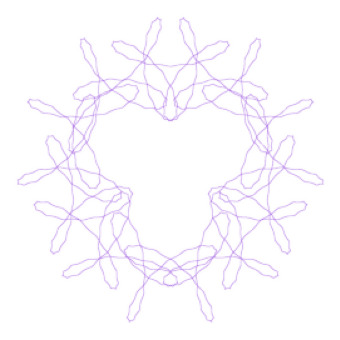

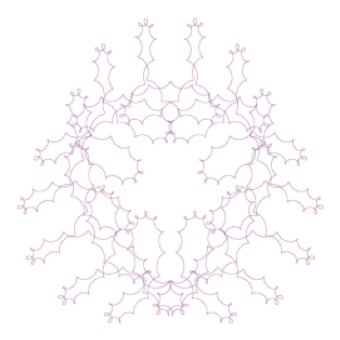

In [43]:
# .pdf for many images
from matplotlib.backends.backend_pdf import PdfPages
pl.rcParams["figure.figsize"] = [7.00, 3.50]
pl.rcParams["figure.autolayout"] = True
filename = "multiplot_img.pdf"
page = PdfPages(filename)
imgs, colors = [img1, img2], [rc1, rc2]
for i in range(2):
    fig = pl.figure()
    pl.imshow(imgs[i])
    pl.axis('off')
    fig.savefig(page, format='pdf')
page.close()

Video files || Archivos de video

In [60]:
from celluloid import Camera
from IPython.display import display, HTML
linear = lambda a, b, x: a * np.array(x) + b
sum_squared_errors = lambda y, y_predict: ((y - y_predict) ** 2).sum()
loss = lambda y, a, b, x: sum_squared_errors(y, linear(a, b, x))
avg_loss = lambda y, a, b, x, n: np.sqrt(loss(y, a, b, x) / n)
a, b, n, steps = 3, 8, 100, 400; x = np.linspace(0, 3, n)
y = linear(a, b, x) + np.random.rand(n)
a_guess, b_guess = -5, 1
def update(x=x, y=y, learning_rate=.01):
    global a_guess, b_guess
    y_predict = linear(a_guess, b_guess, x)
    dydb = 2 * (y_predict - y); dyda = x * dydb
    a_guess -= learning_rate * dyda.mean()
    b_guess -= learning_rate * dydb.mean()
fig = pl.figure(); camera = Camera(fig)
pl.grid()
for i in range(steps):
    pl.scatter(x, y, c='navy', s=10, marker='*', alpha=.7)
    line, = pl.plot(x, linear(a_guess, b_guess, x), c='darkred')
    if (i % 20 == 0):
        text = f"{a=}, {round(a_guess, 2)=}, {b=}, {round(b_guess, 2)=}"
    pl.text(0, -10, text)
    update(); camera.snap()
pl.close()
animation = camera.animate(interval=100)
animation.save('animation.mp4')
display(HTML(animation.to_html5_video()))

File archives || Archivos de archivos

In [45]:
num_images, img_size_out = 50, 256
images = np.zeros((num_images, img_size_out, img_size_out, 3),
                  dtype=np.float32)
labels = np.zeros((num_images,), dtype=np.int32)
targets = np.zeros((num_images, 2), dtype=np.float32)
colors = np.zeros((num_images, 3), dtype=np.float32)
for i in range(num_images):
    if (i + 1) % int(.2 * num_images) == 0:
        print('=>', end='', flush=True)
    img, rc, (a, b, c) = next(g)
    images[i, :, :, :] = img
    labels[i], targets[i,0], targets[i,1] = b-3, a, c
    colors[i,:] = rc
h5f = 'ArtificialImages' + str(img_size_out) + '.h5'
with h5py.File(h5f, 'w') as f:
    f.create_dataset('images', data=images, compression='gzip')
    f.create_dataset('labels', data=labels, compression='gzip')
    f.create_dataset('targets', data=targets, compression='gzip')
    f.create_dataset('colors', data=colors, compression='gzip')
print('\tfile size: %s' % list(os.stat(h5f))[6])

=>=>=>=>=>	file size: 12848771


['colors', 'images', 'labels', 'targets']


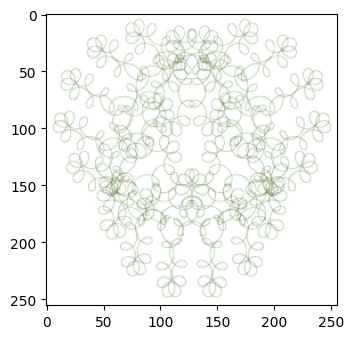

In [46]:
with h5py.File(h5f,'r') as f:
    keys = list(f.keys()); print(keys)
    images = np.array(f[keys[1]], dtype='float32')
    labels = np.array(f[keys[2]], dtype='int32')
    targets = np.array(f[keys[3]], dtype='float32')
    colors = np.array(f[keys[0]], dtype='float32')
pl.imshow(images[-1]);

In [47]:
def append_zipfile(zip_file, file_):
    with zipfile.ZipFile(zip_file, mode='a') as zf:
        zf.write(file_)
def load_file(path, file_):
    input_file = urllib.request.urlopen(path + file_)
    output_file = open(file_,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
def create_stream(path, file_list):
    for file_ in file_list:
        load_file(path, file_)
        yield file_
path = 'https://raw.githubusercontent.com/pandas-dev/pandas/'+\
       'main/pandas/tests/io/data/csv/'
file_list = ['banklist.csv','tips.csv','iris.csv']
for f in create_stream(path, file_list):
    append_zipfile("example.zip", f)

In [48]:
with zipfile.ZipFile("example.zip", mode="r") as zf:
    for info in zf.infolist():
        print(f"file: {info.filename}",
              f"modified: {datetime.datetime(*info.date_time)}",
              f"normal size: {info.file_size} bytes",
              f"compressed size: {info.compress_size} bytes",
              "-" * 20, sep="\n")
    # the file is not closed / el archivo no está cerrado
    print(not zf.fp)

file: banklist.csv
modified: 2023-12-08 02:43:06
normal size: 41417 bytes
compressed size: 41417 bytes
--------------------
file: tips.csv
modified: 2023-12-08 02:43:06
normal size: 7943 bytes
compressed size: 7943 bytes
--------------------
file: iris.csv
modified: 2023-12-08 02:43:06
normal size: 4600 bytes
compressed size: 4600 bytes
--------------------
False


In [49]:
# the file is closed / el archivo está cerrado
print(not zf.fp)

True


In [50]:
with tarfile.open('example.tar', mode='w') as tar:
    for file in file_list: tar.add(file)
with tarfile.open('example.tar', mode='r') as tar:
    for member in tar.getmembers(): print(member.name)

banklist.csv
tips.csv
iris.csv
